In [ ]:
# Установка Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Загрузка Spark
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# Распаковка Spark
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Установка PySpark
!pip install -q findspark

tar: spark-3.5.0-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
from pyspark.sql.functions import mean, stddev, variance, corr, count

In [ ]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

# Создание Spark-сессии
spark = SparkSession.builder \
    .appName("Google Colab Spark Example") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Проверка
print("Spark version:", spark.version)

Spark version: 3.5.3


In [ ]:
# Загрузка данных
dim_branches = spark.read.csv("/content/updated_branches.csv", header=True, inferSchema=True)
dim_employees = spark.read.csv("/content/updated_employees.csv", header=True, inferSchema=True)
dim_periods = spark.read.csv("/content/updated_periods.csv", header=True, inferSchema=True)
fact_table = spark.read.csv("/content/updated_fact_table.csv", header=True, inferSchema=True)

In [ ]:
dim_branches.printSchema()
dim_branches.show(5)

root
 |-- Branch_ID: integer (nullable = true)
 |-- City: string (nullable = true)

+---------+-------------+
|Branch_ID|         City|
+---------+-------------+
|      103|      Detroit|
|      102|       Boston|
|      101|      Seattle|
|      104|  Los Angeles|
|      103|San Francisco|
+---------+-------------+
only showing top 5 rows



In [ ]:
dim_employees.printSchema()
dim_employees.show(5)

root
 |-- Employee_ID: integer (nullable = true)
 |-- Full_Name: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Hire_Date: date (nullable = true)
 |-- Department: string (nullable = true)
 |-- Branch_ID: integer (nullable = true)

+-----------+----------+----------+----------+----------+---------+
|Employee_ID| Full_Name|  Position| Hire_Date|Department|Branch_ID|
+-----------+----------+----------+----------+----------+---------+
|       8270|Employee_1|Consultant|2015-01-01|        IT|      103|
|       1860|Employee_2|   Manager|2015-01-08|Operations|      103|
|       6390|Employee_3|Consultant|2015-01-15|     Sales|      102|
|       6191|Employee_4|   Analyst|2015-01-22|        HR|      101|
|       6734|Employee_5|   Analyst|2015-01-29|Operations|      104|
+-----------+----------+----------+----------+----------+---------+
only showing top 5 rows



In [ ]:
dim_periods.printSchema()
dim_periods.show(5)

root
 |-- Period: timestamp (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)

+-------------------+-----+----+-------+
|             Period|Month|Year|Quarter|
+-------------------+-----+----+-------+
|2024-01-01 00:00:00|    1|2024|      1|
|2024-02-01 00:00:00|    2|2024|      1|
|2024-03-01 00:00:00|    3|2024|      1|
|2024-04-01 00:00:00|    4|2024|      2|
|2024-05-01 00:00:00|    5|2024|      2|
+-------------------+-----+----+-------+
only showing top 5 rows



In [ ]:
fact_table.printSchema()
fact_table.show(5)

root
 |-- Payroll_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Gross_Amount: double (nullable = true)
 |-- Tax_Amount: double (nullable = true)
 |-- Other_Deductions: double (nullable = true)
 |-- Net_Amount: double (nullable = true)
 |-- Payment_Date: date (nullable = true)
 |-- Branch_ID: integer (nullable = true)

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+------------+---------+
|Payroll_ID|Employee_ID|             Period|      Gross_Amount|        Tax_Amount|  Other_Deductions|        Net_Amount|Payment_Date|Branch_ID|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+------------+---------+
|         1|       8270|2024-01-01 00:00:00| 4571.224630040331|1616.7293363717906| 292.9680432694675|2661.5272503990727|  2024-01-31|      103|
|         2|       1860|2024-0

In [ ]:
# 3. Объединение таблиц
data = fact_table \
    .join(dim_employees, fact_table["Employee_ID"] == dim_employees["Employee_ID"], "left") \
    .join(dim_branches, fact_table["Branch_ID"] == dim_branches["Branch_ID"], "left") \
    .join(dim_periods, fact_table["Period"] == dim_periods["Period"], "left")

In [ ]:
# 4. Базовая информация о данных
data.printSchema()
data.show(2, 100, True)

root
 |-- Payroll_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Gross_Amount: double (nullable = true)
 |-- Tax_Amount: double (nullable = true)
 |-- Other_Deductions: double (nullable = true)
 |-- Net_Amount: double (nullable = true)
 |-- Payment_Date: date (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Full_Name: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Hire_Date: date (nullable = true)
 |-- Department: string (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)

-RECORD 0-------------------------------
 Payroll_ID       | 1                   
 Employee_ID      | 8270                
 

In [ ]:
# 5. Расчёт базовых статистик
stat_summary = data.select(
    mean("Gross_Amount").alias("avg_salary"),
    stddev("Gross_Amount").alias("stddev_salary"),
    variance("Gross_Amount").alias("variance_salary"),
    count("Gross_Amount").alias("count_salary")
)

stat_summary.show()

+-----------------+-----------------+----------------+------------+
|       avg_salary|    stddev_salary| variance_salary|count_salary|
+-----------------+-----------------+----------------+------------+
|6437.437028309588|2979.574109558692|8877861.87435247|        4440|
+-----------------+-----------------+----------------+------------+



In [ ]:
from pyspark.sql.functions import min, max

# Additional calculations: minimum, maximum, percentiles
salary_stats = data.select(
    min("Gross_Amount").alias("min_salary"),
    max("Gross_Amount").alias("max_salary")
)

# Approximate percentiles for salary (25th, 50th (median), 75th)
percentiles = data.approxQuantile("Gross_Amount", [0.25, 0.5, 0.75], 0.01)

# Convert to Pandas for visualization
salary_distribution = data.select("Gross_Amount").toPandas()



In [ ]:
# Import visualization libraries
import matplotlib.pyplot as plt
import pandas as pd

# Display statistics
salary_stats_df = pd.DataFrame({
    "Metric": ["Min Salary", "Max Salary", "25th Percentile", "Median (50th Percentile)", "75th Percentile"],
    "Value": [
        salary_stats.collect()[0]["min_salary"],
        salary_stats.collect()[0]["max_salary"],
        percentiles[0],
        percentiles[1],
        percentiles[2]
    ]
})
print(salary_stats_df)



                     Metric         Value
0                Min Salary    762.253113
1                Max Salary  17380.056114
2           25th Percentile   3964.428775
3  Median (50th Percentile)   5958.280618
4           75th Percentile   8358.094570


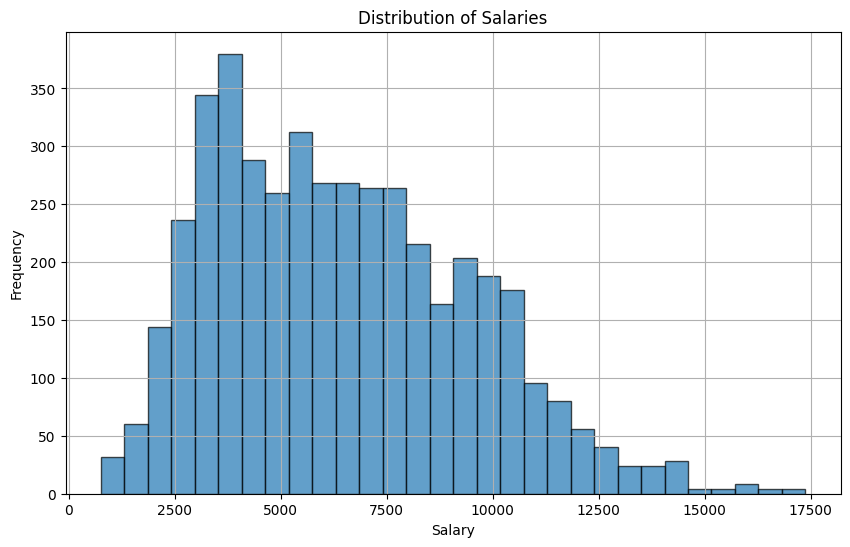

In [ ]:
# Plot histogram of salary distribution
plt.figure(figsize=(10, 6))
plt.hist(salary_distribution["Gross_Amount"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Salaries")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



•	Наибольшее количество зарплат сосредоточено в диапазоне 4,000–7,500, так как в этом диапазоне столбцы самые высокие.

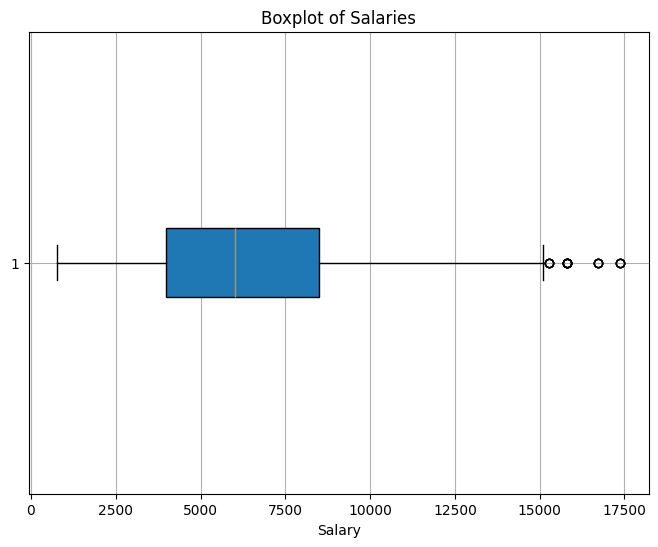

In [ ]:
# Plot boxplot for salary distribution
plt.figure(figsize=(8, 6))
plt.boxplot(salary_distribution["Gross_Amount"], vert=False, patch_artist=True)
plt.title("Boxplot of Salaries")
plt.xlabel("Salary")
plt.grid(True)
plt.show()

In [ ]:

# 6. Корреляция между зарплатой и количеством завершённых проектов
correlation = data.select(corr("Gross_Amount", "Tax_Amount").alias("correlation_salary_taxes"))
correlation.show()

+------------------------+
|correlation_salary_taxes|
+------------------------+
|      0.9038274164169642|
+------------------------+



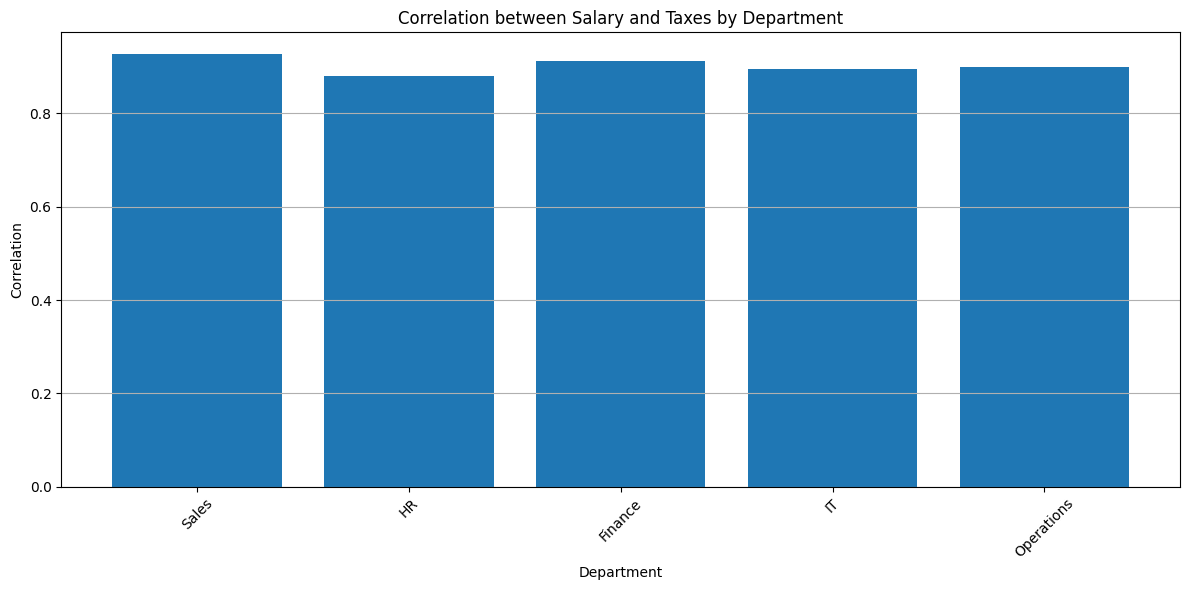

In [ ]:
# Correlation between salary and taxes by department
department_correlation = data.groupBy("Department").agg(
    corr("Gross_Amount", "Tax_Amount").alias("correlation_salary_taxes")
)

# Convert to Pandas for easier visualization
department_correlation_df = department_correlation.toPandas()

# Plot correlation by department
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(department_correlation_df["Department"], department_correlation_df["correlation_salary_taxes"])
plt.title("Correlation between Salary and Taxes by Department")
plt.xlabel("Department")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

График показывает, что во всех департаментах корреляция между зарплатой и налогами близка к 1 (почти идеальная прямая зависимость).


Это логично, поскольку налоги часто рассчитываются как фиксированный процент от зарплаты, что автоматически создаёт такую корреляцию.

In [ ]:
# Вывести данные в консоли
print(department_correlation_df)

# Если нужно сохранить в файл:
department_correlation_df.to_csv("department_correlation.csv", index=False)

   Department  correlation_salary_taxes
0       Sales                  0.927200
1          HR                  0.880388
2     Finance                  0.911129
3          IT                  0.895651
4  Operations                  0.899520


In [ ]:

# 7. Средняя зарплата по филиалам
from pyspark.sql.functions import mean

# Средняя зарплата по филиалам (например, по городам)
avg_salary_by_branch = data.groupBy("City").agg(
    mean("Gross_Amount").alias("avg_salary")
)

avg_salary_by_branch.show()

+-------------+------------------+
|         City|        avg_salary|
+-------------+------------------+
|      Phoenix| 6281.992748068167|
|  Los Angeles|6267.0891447603835|
|San Francisco|  6366.02819576488|
|      Detroit|  6366.02819576488|
|     Portland|6267.0891447603835|
|       Austin|6267.0891447603835|
|      Chicago|6267.0891447603835|
|      Atlanta|  6366.02819576488|
|    Las Vegas| 6281.992748068167|
|      Seattle| 6847.999347761758|
|      Houston|  6366.02819576488|
|        Miami| 6281.992748068167|
|      Orlando| 6847.999347761758|
|     New York| 6847.999347761758|
|       Denver| 6847.999347761758|
|       Boston| 6281.992748068167|
+-------------+------------------+



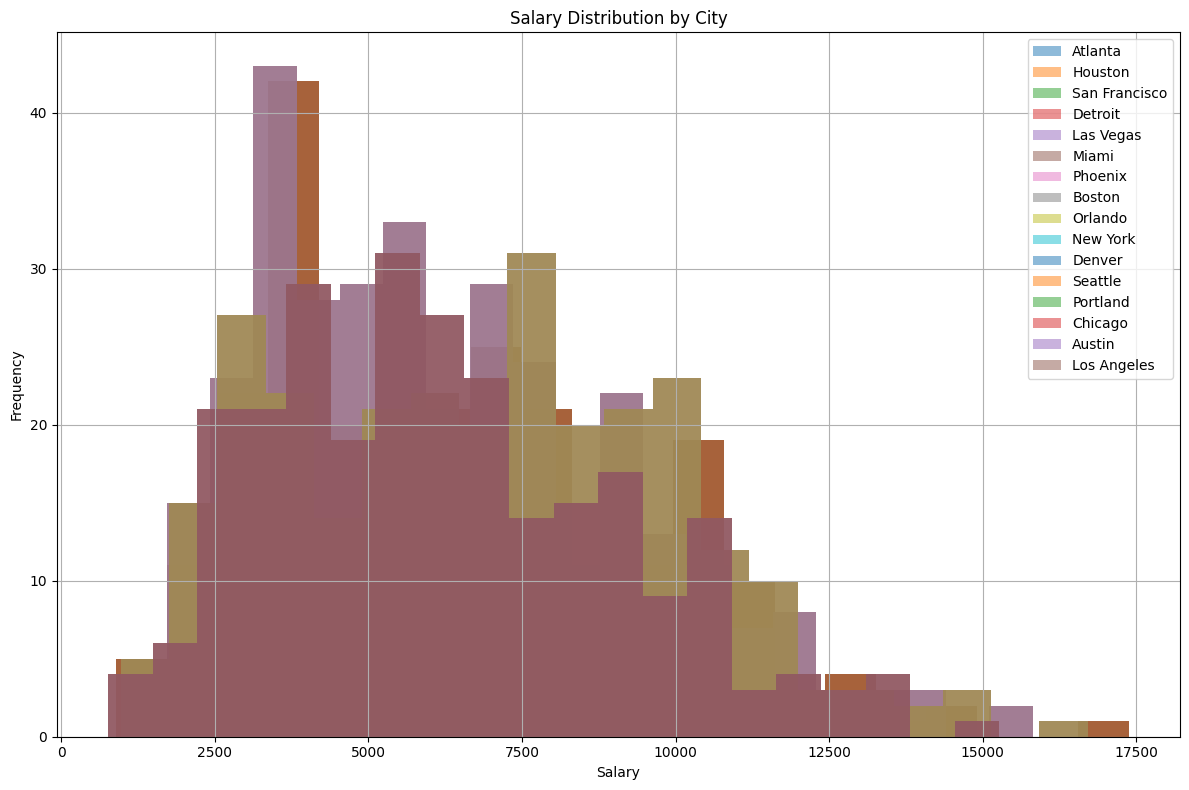

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
salary_by_city = data.select("City", "Gross_Amount").toPandas()

# Plot histogram for each city
cities = salary_by_city["City"].unique()
plt.figure(figsize=(12, 8))

for city in cities:
    city_data = salary_by_city[salary_by_city["City"] == city]["Gross_Amount"]
    plt.hist(city_data, bins=20, alpha=0.5, label=city)

plt.title("Salary Distribution by City")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

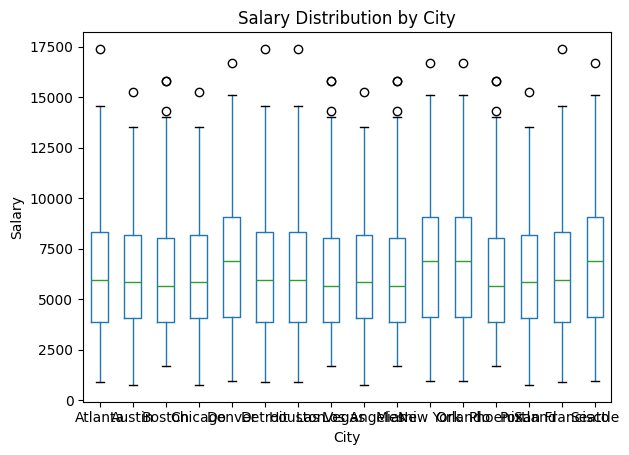

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Преобразование PySpark DataFrame в Pandas DataFrame
salary_by_city_pandas = salary_by_city.toPandas()

# Построение boxplot
plt.figure(figsize=(10, 6))
salary_by_city_pandas.boxplot(column="Gross_Amount", by="City", grid=False)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.suptitle("")  # Удаление автоматического заголовка
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

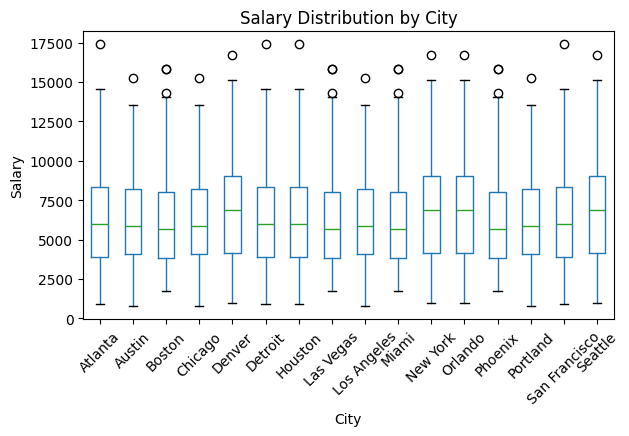

In [ ]:
# Улучшение читаемости графика
plt.figure(figsize=(14, 8))

# Построение boxplot
salary_by_city_pandas.boxplot(column="Gross_Amount", by="City", grid=False)

# Улучшение оси X
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.xticks(rotation=45, fontsize=10)  # Поворот меток оси X для улучшения читаемости
plt.tight_layout()
plt.suptitle("")  # Удаление автоматического заголовка от Pandas
plt.show()

In [ ]:
from pyspark.sql.functions import to_date, col, year, month

# 8. Работа с временными данными

data = data.withColumn("date_column", to_date(col("Payment_Date"), "yyyy-MM-dd"))
data = data.withColumn("year", year(col("date_column"))).withColumn("month", month(col("date_column")))

# Отображение данных с временными колонками
data.select("date_column", "year", "month").show(5)

+-----------+----+-----+
|date_column|year|month|
+-----------+----+-----+
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-02-29|2024|    2|
+-----------+----+-----+
only showing top 5 rows



In [ ]:
monthly_avg_salary = data.groupBy("year", "month").agg(mean("Gross_Amount").alias("avg_salary"))
monthly_avg_salary.show()

+----+-----+------------------+
|year|month|        avg_salary|
+----+-----+------------------+
|2031|   12| 13318.74832632965|
|2036|   11| 7914.001533213815|
|2045|    6| 7123.767508785561|
|2070|    2| 6288.703146655554|
|2106|    2| 6472.790662777959|
|2059|    4|3023.3530367020276|
|2047|    4| 8557.470294803046|
|2079|    2| 4298.345755808936|
|2089|    8|3345.9227490330627|
|2041|    1|  8524.60008920691|
|2082|   12| 5618.382559946418|
|2101|    8| 4403.508256748927|
|2028|   10| 2282.916825652202|
|2031|    2| 4577.541890862519|
|2035|    7| 7602.756137707532|
|2056|   10|11138.979497020313|
|2089|    1|11545.903435174576|
|2093|    4| 4081.189615318917|
|2042|    2| 5189.380364962846|
|2044|    2| 4185.183384698482|
+----+-----+------------------+
only showing top 20 rows



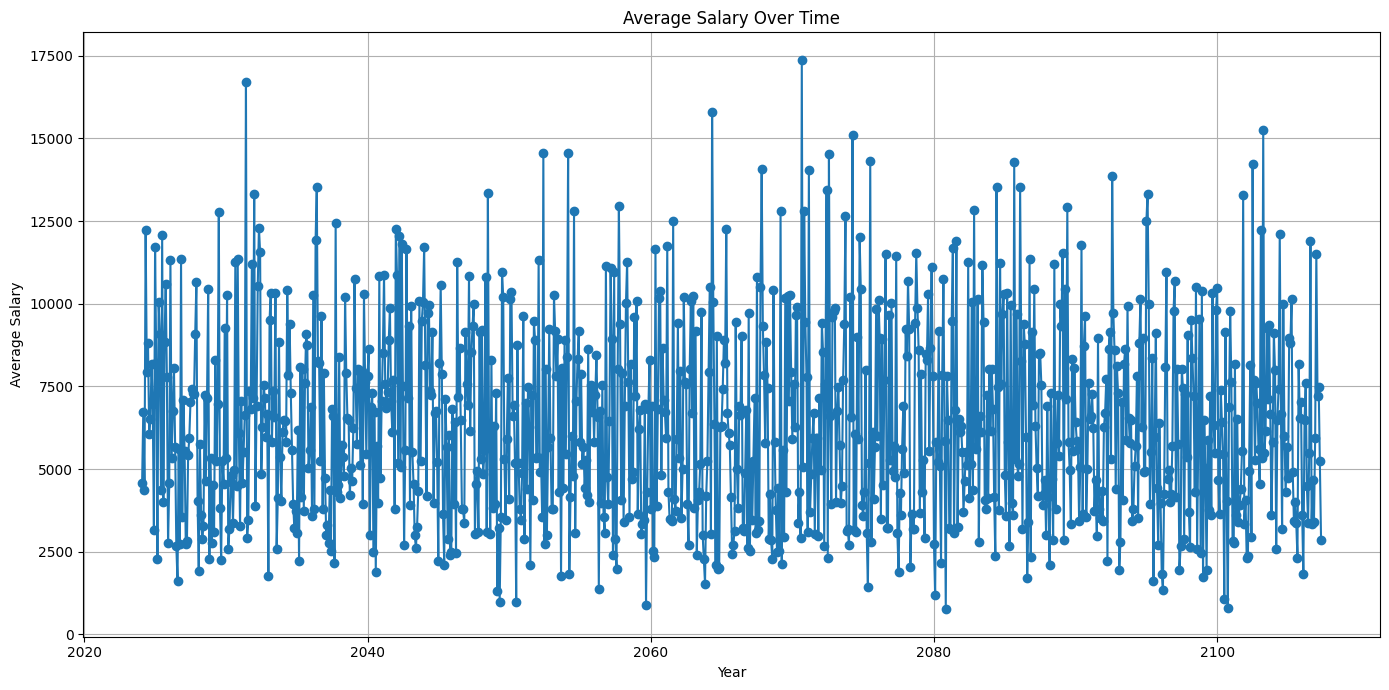

In [ ]:

# Рассчёт средней зарплаты по годам и месяцам
monthly_avg_salary_df = data.groupBy("year", "month").agg(mean("Gross_Amount").alias("avg_salary")).toPandas()

# Сортировка данных для удобства визуализации
monthly_avg_salary_df = monthly_avg_salary_df.sort_values(by=["year", "month"])

# Построение графика
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(
    monthly_avg_salary_df["year"] + monthly_avg_salary_df["month"] / 12,
    monthly_avg_salary_df["avg_salary"],
    marker="o",
    linestyle="-",
    label="Avg Salary"
)
plt.title("Average Salary Over Time")
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.grid(True)
plt.tight_layout()
plt.show()


	1.	Общая картина:
	•	Средняя зарплата заметно колеблется с течением времени, варьируясь от около 2000 до почти 10000.
	•	Амплитуда изменений остаётся высокой, что указывает на значительные колебания зарплат между разными месяцами и годами.
	2.	Шум в данных:
	•	Количество точек и резкие скачки между значениями могут быть связаны с наличием выбросов или нерегулярным распределением данных в разных временных интервалах.
	3.	Нестабильные тенденции:
	•	Отсутствует чёткая долгосрочная тенденция (рост или снижение зарплат), что может указывать на:
	•	Несогласованность данных по периодам.
	•	Влияние внешних факторов или особенности расчёта данных.

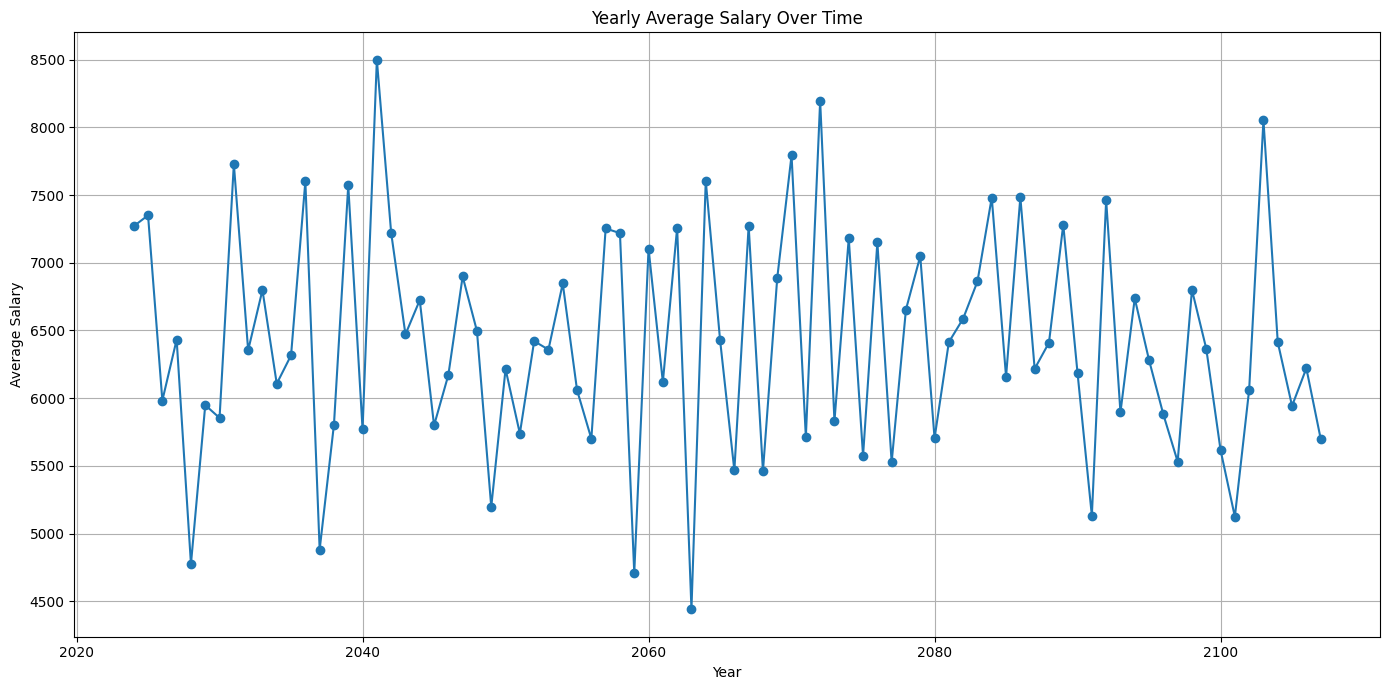

In [ ]:
# Рассчёт средней зарплаты по годам
yearly_avg_salary_df = data.groupBy("year").agg(mean("Gross_Amount").alias("avg_salary")).toPandas()

# Сортировка данных по годам
yearly_avg_salary_df = yearly_avg_salary_df.sort_values(by="year")

# Построение графика средней зарплаты по годам
plt.figure(figsize=(14, 7))
plt.plot(
    yearly_avg_salary_df["year"],
    yearly_avg_salary_df["avg_salary"],
    marker="o",
    linestyle="-",
    label="Yearly Avg Salary"
)
plt.title("Yearly Average Salary Over Time")
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

Рекомендации:
	1.	Углублённый анализ выбросов:
	•	Исследовать причины экстремальных значений зарплат (как низких, так и высоких).
	•	Проверить, связаны ли они с определёнными должностями, филиалами или департаментами.
	2.	Сравнение с внешними факторами:
	•	Сравнить динамику зарплат с инфляцией, экономическими кризисами или внутренними событиями в компании.
	3.	Долгосрочный анализ:
	•	Рассмотреть данные по десятилетиям для устранения шума и выявления долгосрочных трендов.
	4.	Сегментация данных:
	•	Провести дополнительный анализ по должностям, филиалам и департаментам, чтобы выделить ключевые группы и их особенности.